###Mount drive

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive', force_remount=True)

################################################
###### Enter Folder which has your data ########
################################################
FOLDERNAME = "ee782"
assert FOLDERNAME is not None, "[!] Enter the foldername."
path = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(path)

Mounted at /content/drive


###Get the required stuff (Run this the first time only)

In [ ]:
import requests  
train_url = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/TrainingSet.rar"
examples_url = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/P01-images_with_manual_contours.zip"
test1_url = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/Test1Set.rar"
test1_contour = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2019/07/Test1SetContours.zip"
test2_url = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/Test2Set.rar"
test2_contour ="http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2019/07/Test2SetContours.zip"
evalCode_url = "http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/RVSCEvaluationCode.zip"

####Train

In [ ]:
r = requests.get(train_url, stream = True) 

with open("TrainingSet.rar", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
###### Enter Folder which has your data ########
#password: ceusmdppma
!unrar x "TrainingSet.rar" -y

####Examples

In [ ]:
r = requests.get(examples_url, stream = True) 

with open("P01-images_with_manual_contours.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
!unzip P01-images_with_manual_contours.zip

Archive:  P01-images_with_manual_contours.zip
   creating: P01-images_with_manual_contours/
  inflating: P01-images_with_manual_contours/P01-0080.png  
  inflating: P01-images_with_manual_contours/P01-0100.png  
  inflating: P01-images_with_manual_contours/P01-0108.png  
  inflating: P01-images_with_manual_contours/P01-0120.png  
  inflating: P01-images_with_manual_contours/P01-0128.png  
  inflating: P01-images_with_manual_contours/P01-0140.png  
  inflating: P01-images_with_manual_contours/P01-0148.png  
  inflating: P01-images_with_manual_contours/P01-0160.png  
  inflating: P01-images_with_manual_contours/P01-0168.png  
  inflating: P01-images_with_manual_contours/P01-0180.png  
  inflating: P01-images_with_manual_contours/P01-0188.png  
  inflating: P01-images_with_manual_contours/P01-0200.png  
  inflating: P01-images_with_manual_contours/P01-0208.png  
  inflating: P01-images_with_manual_contours/P01-0220.png  
  inflating: P01-images_with_manual_contours/P01-0228.png  
  inflat

####Test

####Evaluation code

Details given [here](http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/RVSCEvaluationCodeHelpFile.pdf)

In [ ]:
r = requests.get(evalCode_url, stream = True) 

with open("RVSCEvaluationCode.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
!unzip RVSCEvaluationCode.zip 

Archive:  RVSCEvaluationCode.zip
  inflating: RVSCEvaluationCode/compare_rv_contours.m  
  inflating: RVSCEvaluationCode/corrcoef_regression.m  
  inflating: RVSCEvaluationCode/edgelist2mask.m  
  inflating: RVSCEvaluationCode/intline.m  
  inflating: RVSCEvaluationCode/main_perf_assessment.m  
  inflating: RVSCEvaluationCode/mypoly2mask.m  
  inflating: RVSCEvaluationCode/poly2edgelist.m  


###Viewing one image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
!pip install pydicom
import pydicom
%matplotlib inline

     |████████████████████████████████| 35.5MB 1.5MB/s 


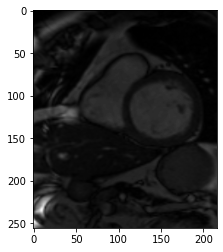

In [ ]:
#training image
path = "/content/drive/Shared drives/EE782_Assignment_1/"
img1 = pydicom.dcmread(path+"TrainingSet/patient01/P01dicom/P01-0080.dcm")
plt.imshow(img1.pixel_array, cmap = 'gray')

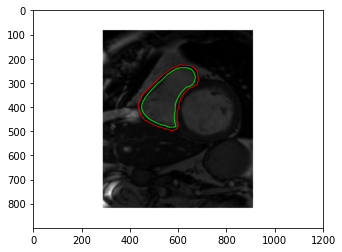

In [ ]:
#example image with manual contours
img = plt.imread("P01-images_with_manual_contours/P01-0080.png")
plt.imshow(img);

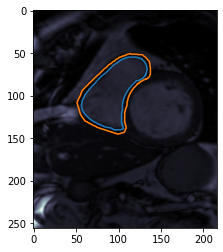

In [ ]:
#forming contour from in the train set
f = open("/content/TrainingSet/patient01/P01contours-manual/P01-0080-icontour-manual.txt", "r")
x, y = [], []
for line in f.readlines():
  xi, yi = line.split();
  x.append(float(xi))
  y.append(float(yi))
f.close()
plt.subplot();
plt.imshow(img1.pixel_array, cmap = plt.cm.bone);
plt.plot(x,y);
f = open("/content/TrainingSet/patient01/P01contours-manual/P01-0080-ocontour-manual.txt", "r")
x, y = [], []
for line in f.readlines():
  xi, yi = line.split();
  x.append(float(xi))
  y.append(float(yi))
f.close()
plt.plot(x,y);

#How do I find the area for IOU loss?

###Forming the dataset
The dataset is explained [here](http://pagesperso.litislab.fr/cpetitjean/wp-content/uploads/sites/19/2016/05/RVSC_images_contours_format.pdf)

In [ ]:
import torch
from torch import nn
import torchvision.transforms as T
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import transforms, utils
import pandas as pd
import os

class RVSCDataset(Dataset):
  def __init__(self, files = [], root_dir="TrainingSet", transform = None):
    '''Args:
    files: list of paths to reference files of all patients eg: P01list.txt
    root_dir: where the Training set is stored
    transform: callable, optional- zero center, etc. torchvision.transform
    '''
    self.transform = transform
    self.root_dir = root_dir
    path = os.getcwd()
    os.chdir(self.root_dir)
    self.idf, self.odf = self.__readlists(files)
    os.chdir(path)

  def __readlists(self,files):
    df = pd.read_csv(files[0], sep = "\\", header = None)
    #df = pd.DataFrame(columns=[".","1","2","3"])
    for i in files[1:]:
      x = pd.read_csv( i, sep = "\\", header=None)
      df = df.append(x, ignore_index = True)
    #inner contour
    idf = df[df[3].str[9] == "i"]
    idf =idf.reset_index()
    #outer contour
    odf = df[df[3].str[9] == "o"]
    odf = odf.reset_index()
    #sanity check + return
    #assert (idf.index == odf.index).all()
    return idf, odf

  def getid(self, idx):
    return self.idf[3].str[:8][idx]
  def getpatient(self, idx):
    return self.idf[1][idx]

  def readcontour(self, idx):
    ipath = os.path.join(self.root_dir,
                         self.idf[1][idx],
                         self.idf[2][idx],
                         self.idf[3][idx],)
    opath = os.path.join(self.root_dir,
                         self.odf[1][idx],
                         self.odf[2][idx],
                         self.odf[3][idx],)
    icontour = pd.read_csv(ipath, sep=' ', header=None)
    ocontour = pd.read_csv(opath, sep=' ', header=None)

    return icontour, ocontour
  def __len__(self):
    return len(self.idf)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.item()
    id = pd.Series(self.getid(idx))
    patient = pd.Series(self.getpatient(idx))
    if len(id) == 1:
      id = id[0]
      patient = patient[0]
      path = os.path.join(self.root_dir, patient, 
                          id[:3]+"dicom", id+".dcm")
      im = pydicom.dcmread(path).pixel_array
      if self.transform is not None:
        im = self.transform(im)
      icontour, ocontour = self.readcontour(idx)
      sample = {'image': im, 
                'icontour': icontour, 
                'ocontour': ocontour}
      return sample
    else:
      raise Exception("can only return single item")
      # samples = []
      # for i in range(len(id)):
      #   patient = self.getpatient(idx)
      #   path = os.path.join(self.root_dir, patient[i], 
      #                       id[i]+"dicom", id[i]+".dcm")
      #   im = pydicom.dcmread(path).pixel_array
      #   if self.transform is not None:
      #     im = self.transform(im)
      #   icontour, ocontour = self.readcontour(idx)
      #   sample = {'image': im, 
      #             'icontour': icontour, 
      #             'ocontour': ocontour}
      #   samples.append(sample)

In [ ]:
files = []
for i in range(1,17):
  if i < 10:
    files.append("patient0"+str(i)+"/P0"+str(i)+"list.txt")
  else:
    files.append("patient"+str(i)+"/P"+str(i)+"list.txt")
root_dir = os.path.join(path, "TrainingSet")
#root_dir
rsvc_dataset = RVSCDataset(files = files, root_dir = root_dir)

In [ ]:
def plot_contours(img, icontour, ocontour):
  plt.imshow(img, cmap=plt.cm.bone)
  plt.plot(np.array(icontour[0]), np.array(icontour[1]), 'g-')
  plt.plot(np.array(ocontour[0]), np.array(ocontour[1]), 'r-')


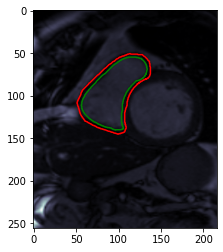

In [ ]:
fig = plt.figure()
i = 0
plt.subplot()
plot_contours(rsvc_dataset[i]['image'],
              rsvc_dataset[i]['icontour'], 
              rsvc_dataset[i]['ocontour'])


###Masks

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
!pip install pydicom
import pydicom

     |████████████████████████████████| 35.5MB 137kB/s 


1045


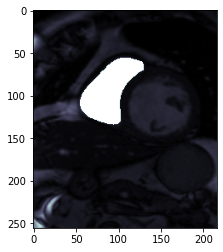

In [ ]:
img_path = "/content/drive/Shared drives/EE782_Assignment_1/TrainingSet/patient01/P01dicom/P01-0100.dcm"
img = pydicom.dcmread(img_path).pixel_array
print(np.max(img))

contour_path = "/content/drive/Shared drives/EE782_Assignment_1/TrainingSet/patient01/P01contours-manual/P01-0100-icontour-manual.txt"
Y, X = [], []
coord = []

with open(contour_path, 'r') as f:
    for line in f:
        y, x = [float(s) for s in line.split()]
        X.append(x)
        Y.append(y)
        coord.append([round(y), round(x)])

#mask = np.zeros(img.shape);
cv.fillPoly(img, pts=[np.array(coord)], color=1200);
plt.imshow(img, cmap=plt.cm.bone);

In [ ]:
# give contour_path as path for icontour file
def create_mask(name):
    p = name.split('-')[0][1:]
    path =  f'/content/drive/Shared drives/EE782_Assignment_1/Test1Set/patient{p}'
    
    patient = name.split('-')[0]
    name_split = name.split('-')
    img_path = f'{path}/{patient}dicom/{name_split[0]}-{name_split[1]}.dcm'
    contour_path = f'{path}/{patient}contours-manual/{name}.txt'
    
    img = pydicom.dcmread(img_path).pixel_array
    coord = []

    with open(contour_path, 'r') as f:
        for line in f:
            y, x = [float(s) for s in line.split()]
            coord.append([round(y), round(x)])

    mask = np.zeros(img.shape)
    cv.fillPoly(mask, pts=[np.array(coord)], color=255)
    cv.imwrite(f'/content/drive/Shared drives/EE782_Assignment_1/Test1Set/patient{p}/P{p}contours-manual/{name}.png', mask)

In [ ]:
%cd /content/drive/Shared drives/EE782_Assignment_1/Test1Set
for folder in os.listdir(os.getcwd()):
    if 'patient' not in folder:
        continue
    id = folder[-2:]
    if(int(id) < 41):
        for file in os.listdir(os.path.join(os.getcwd(), folder, f'P{id}contours-manual')):
            name = file[:-4]
            print(name)
            create_mask(name)

In [ ]:
os.getcwd()

'/content/drive/Shared drives/EE782_Assignment_1/Test1Set'

### Dice Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predict, targets):
        assert predict.shape == targets.shape, 'predict & target shape do not match'
        total_loss = 0

        predict = predict.view(-1)
        targets = targets.view(-1)

        intersection = mp.array((predict.numpy() == targets.numpy()).sum())                       
        dice_loss = 1 - (2.*intersection + 1e-12)/(abs(predict.sum()) + abs(targets.sum()) + 1e-12)

        return dice_loss

In [ ]:
p = 33
impath = f'/content/drive/Shared drives/EE782_Assignment_1/Test2Set/patient{p}/P{p}contours-manual/P{p}-0020-icontour-manual.png'

In [ ]:
im = (plt.imread(impath))
#loss = DiceLoss()

In [ ]:
loss.forward(im,im), loss.forward(im,torch.tensor(img*1.0))

tensor([False, False, False,  ..., False, False, False])
tensor([False, False, False,  ..., False, False, False])


(tensor(-6.7046), tensor(1.0000, dtype=torch.float64))